# Explore FFIs

Just look at FFIs for qualitative understanding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from astropy.io import fits
import astropy.visualization
from fast_histogram import histogram1d

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Campaign 13 is the most recent campaign we have available.  
Let's download it from the [K2 FFI MAST portal](https://archive.stsci.edu/pub/k2/ffi/).  We'll get both the FFI itself and its `unc` companion file.

In [4]:
hdu = fits.open('/Volumes/Truro/ffi/ktwo2017079075530-c13_ffi-cal.fits')

In [5]:
hdu.info()

Filename: /Volumes/Truro/ffi/ktwo2017079075530-c13_ffi-cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      57   ()      
  1  MOD.OUT 2.1    1 ImageHDU        99   (1132, 1070)   float32   
  2  MOD.OUT 2.2    1 ImageHDU        99   (1132, 1070)   float32   
  3  MOD.OUT 2.3    1 ImageHDU        99   (1132, 1070)   float32   
  4  MOD.OUT 2.4    1 ImageHDU        99   (1132, 1070)   float32   
  5  MOD.OUT 3.1    1 ImageHDU        66   (1132, 1070)   float32   
  6  MOD.OUT 3.2    1 ImageHDU        66   (1132, 1070)   float32   
  7  MOD.OUT 3.3    1 ImageHDU        66   (1132, 1070)   float32   
  8  MOD.OUT 3.4    1 ImageHDU        66   (1132, 1070)   float32   
  9  MOD.OUT 4.1    1 ImageHDU        66   (1132, 1070)   float32   
 10  MOD.OUT 4.2    1 ImageHDU        66   (1132, 1070)   float32   
 11  MOD.OUT 4.3    1 ImageHDU        66   (1132, 1070)   float32   
 12  MOD.OUT 4.4    1 ImageHDU        66   (1132, 1070)   float3

The FFIs are comprised of many individual modules and channels, etc.  Let's look at one of them.  Module 13 is near "on-axis" of the optical system: it's in the middle of the field of view and should therefore have better-than-average image quality.

In [6]:
mod13p1 = hdu['MOD.OUT 13.2']

In [7]:
mod13p1.data.shape

(1070, 1132)

In [8]:
mod13p1.data.min()

-347.58362

Negative values foil logarithmic transformations.  Add a bias value of 500.0

In [9]:
dat = mod13p1.data + 500.0
logdat = np.log10(dat)

In [10]:
minmax = astropy.visualization.MinMaxInterval()

In [11]:
vmin, vmax = minmax.get_limits(logdat)
vmin, vmax

(2.1830316, 5.343565)

In [12]:
x = np.linspace(vmin, vmax, 200)
y = histogram1d(logdat.reshape(-1), bins=200, range=(vmin, vmax))

Let's improve the *screen stretch* for readability.

In [13]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(logdat)

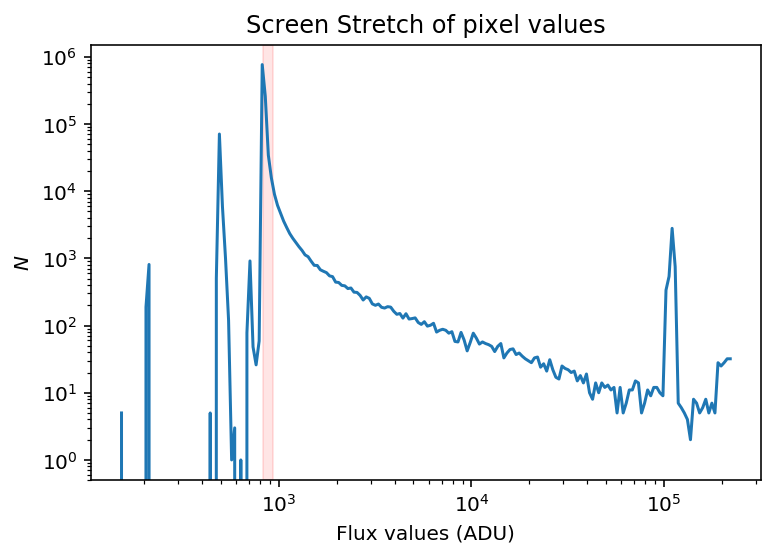

In [14]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

In [15]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

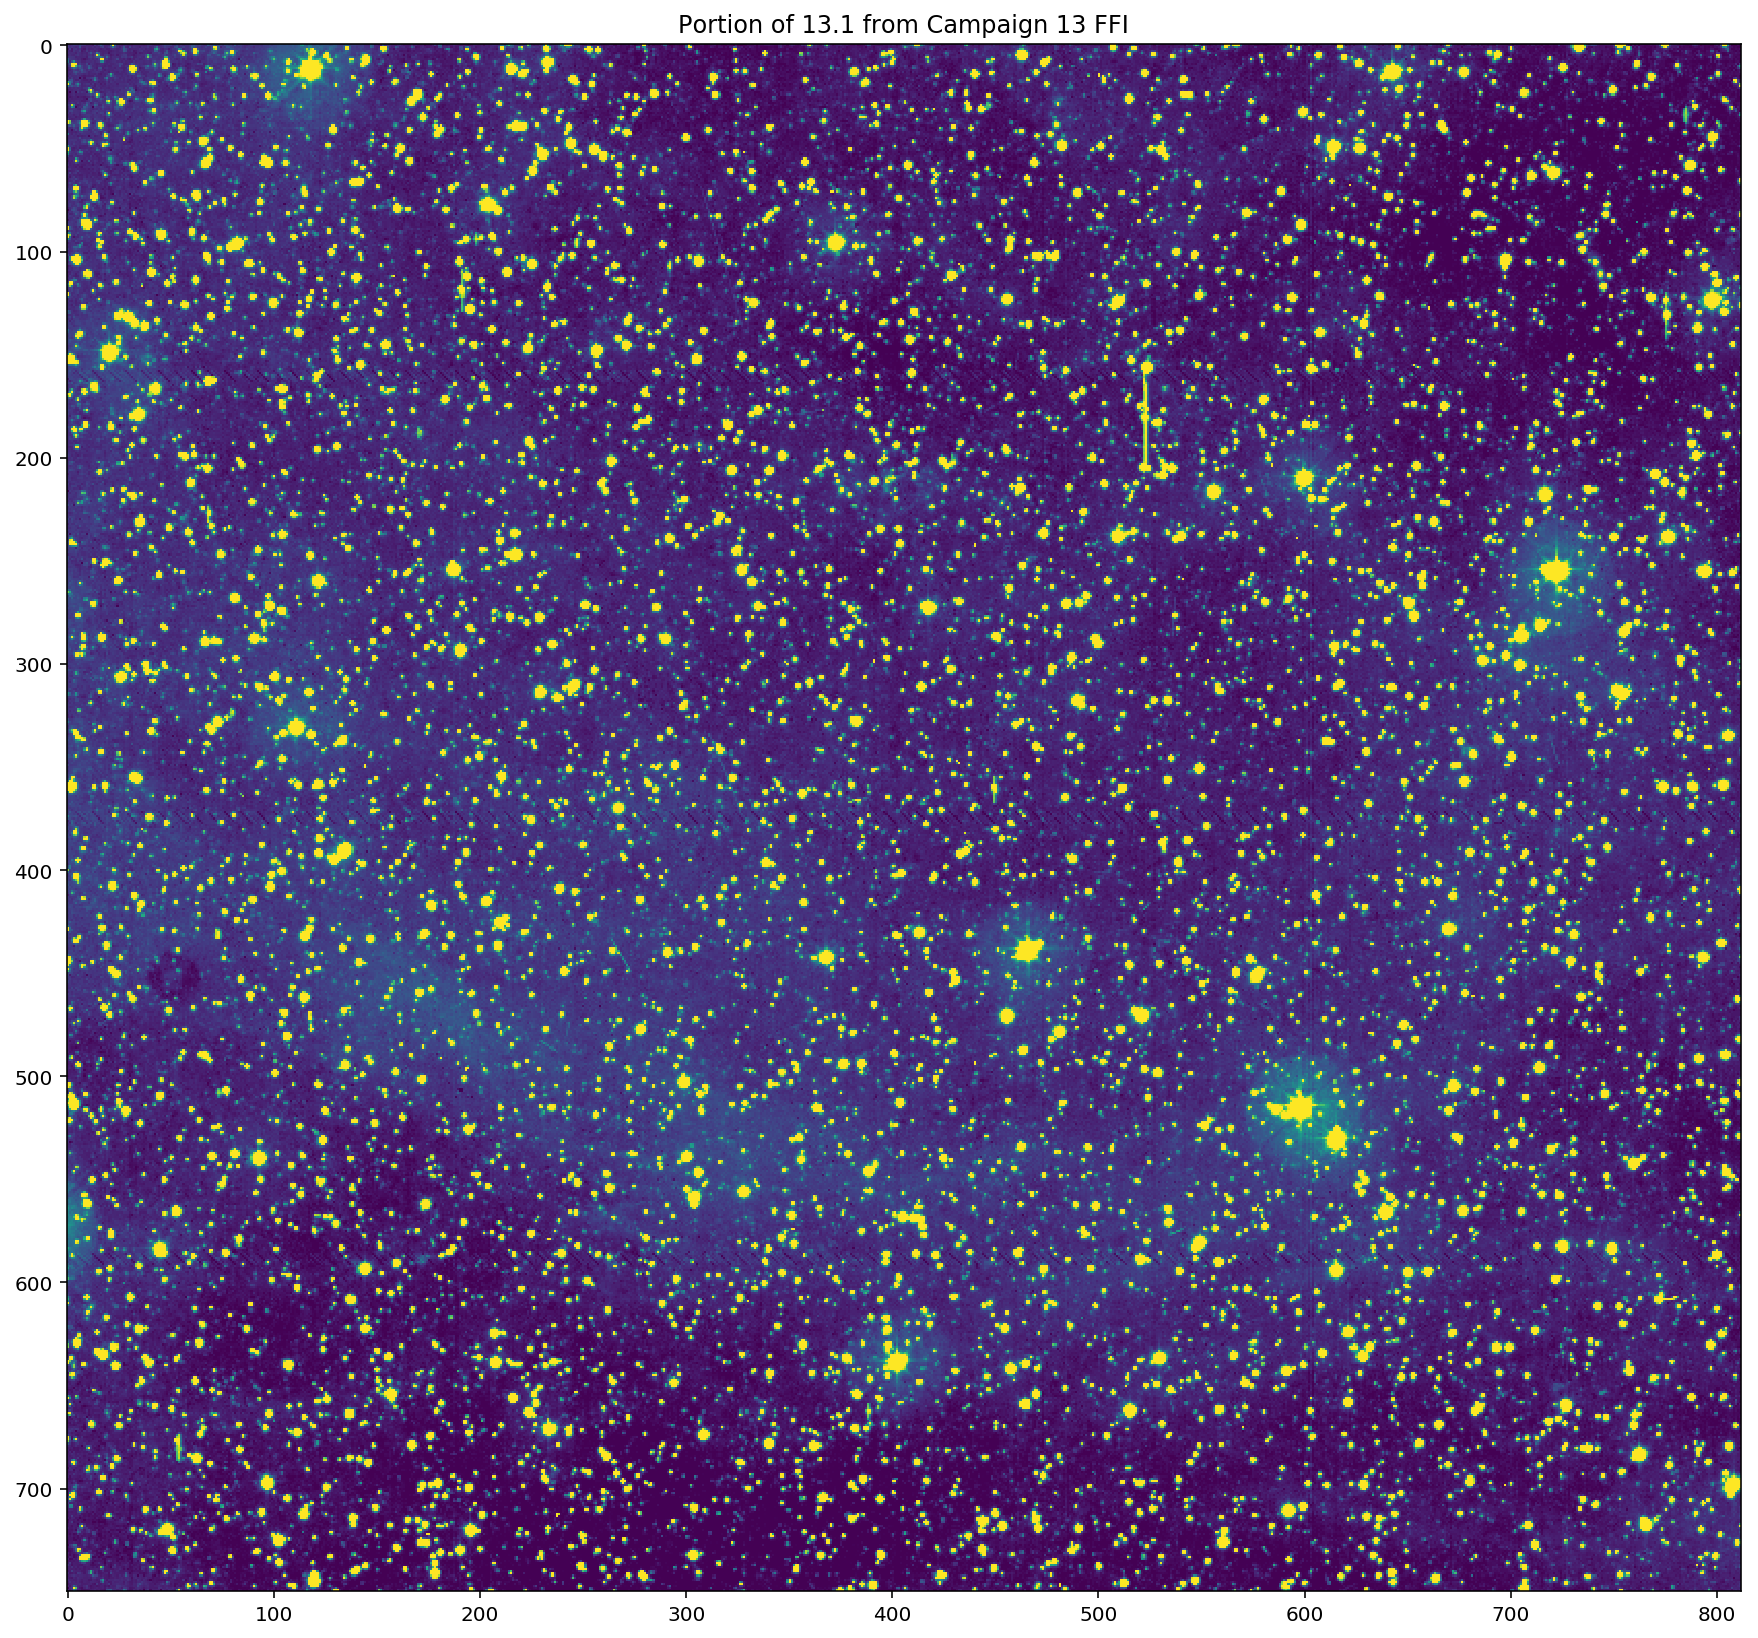

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(dat[270:-50, 270:-50], norm=norm)
plt.title('Portion of 13.1 from Campaign 13 FFI')
plt.savefig('demo_FFI_13p2_data.png', dpi=300, bbox_inches='tight');

Neat! Stars and some artifacts.

In [36]:
250*12

3000

In [17]:
0.5/4

0.125

What does the above image look like if the telescope is drifing through the sky?

Assume the drift rate is: 
$$\omega_d = \dot \theta = 0.5^{\circ} /\mathrm{hour}$$

$$= 0.5^{''} /\mathrm{sec}$$
$$= 0.125 \;\mathrm{pixels}/\mathrm{sec}$$

Kepler possesses both photon accumulation time and a read time:  

$$t_{int} = 6.02 \;\mathrm{sec}$$
$$t_{read} = 0.52 \;\mathrm{sec}$$

$t_{int}$ is the photon accumulation time per frame, while $t_{read}$ is the readout time per frame.

So with $0.5^{\circ} /\mathrm{hour}$ motion, we will have:
$$0.125 \; \frac{\mathrm{pixels}}{\mathrm{sec}} \times 6.54 \; \frac{\mathrm{sec}}{1}$$  
$$0.8175 \; \frac{\mathrm{pixels}}{\mathrm{frame}}$$  

There are 270 frames per net FFI exposure, yielding the 29.4 minute cadence we are used to.

In [18]:
0.125*6.54

0.8175

In [19]:
270.0*6.54/60

29.43

During the 270 frame exopsure, the *net drift* is about 220 pixels:

In [20]:
0.8175*270.0

220.725

Storing and reading out the FFI to the Solid State Recorder (SSR) takes about 15-20 minutes (priv. comm. from Marcie Smith and Doug Caldwell).  That's a shutter open time duty cycle of about:

In [21]:
29.4/(29.4+20)

0.5951417004048583

In [22]:
0.125*20*60.0

150.0

Realistically what this means is that frames will have 220-pixel-long streaks interrupted by an equivalent 150-pixel-long gap in data.

In [23]:
t_int = 6.02
t_read = 0.52

Simulate movement in both $x$ and $y$:

In [24]:
omega_x, omega_y = np.sqrt(2)*0.125, np.sqrt(2)*0.125

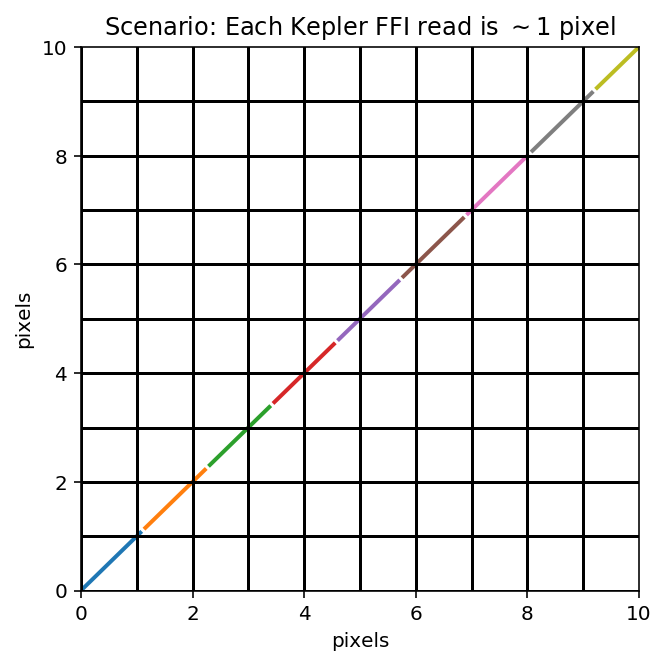

In [25]:
t0, t1, t2 = 0, 6.02, 6.54
x0, y0 = omega_x*t0, omega_y*t0
x1, y1 = omega_x*t1, omega_y*t1
x2, y2 = omega_x*t2, omega_y*t2

plt.figure(figsize=(5,5))

for frame_num in range(12):
    plt.plot([x0, x1], [y0, y1], lw = 2)    
    t0, t1 = t0+t2, t1+t2
    x0, y0 = omega_x*t0, omega_y*t0
    x1, y1 = omega_x*t1, omega_y*t1

for i in range(10):
    plt.axvline(i, color='k')
    plt.axhline(i, color='k')

plt.xlabel('pixels')
plt.ylabel('pixels')
plt.xlim(0,10)
plt.ylim(0,10)
plt.title('Scenario: Each Kepler FFI read is $\sim$1 pixel');

# Simulate the image motion

Let's round the image motion to the nearest integer to make our simulation computationally easier, otherwise we'd have to interpolate on a sub-pixel level. $$0.815 \; \frac{\mathrm{pixels}}{\mathrm{frame}} \approx 1 \frac{\mathrm{pixel}}{\mathrm{frame}}$$  

In [26]:
rolled = dat*0.0

In [27]:
npix = 270
for i in range(npix):
    rolled = rolled+ np.roll(np.roll(dat, i, 0), i,1)/270.0

In [28]:
logrolled = np.log10(rolled)

In [29]:
vmin, vmax = minmax.get_limits(logrolled)
vmin, vmax

(2.8832669, 3.6805511)

In [30]:
x = np.linspace(vmin, vmax, 200)
y = histogram1d(logrolled.reshape(-1), bins=200, range=(vmin, vmax))

In [31]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 60.0)
vmin, vmax = good_interval.get_limits(logrolled)
vmin, vmax

(2.9189852952957152, 2.9670774936676025)

In [32]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

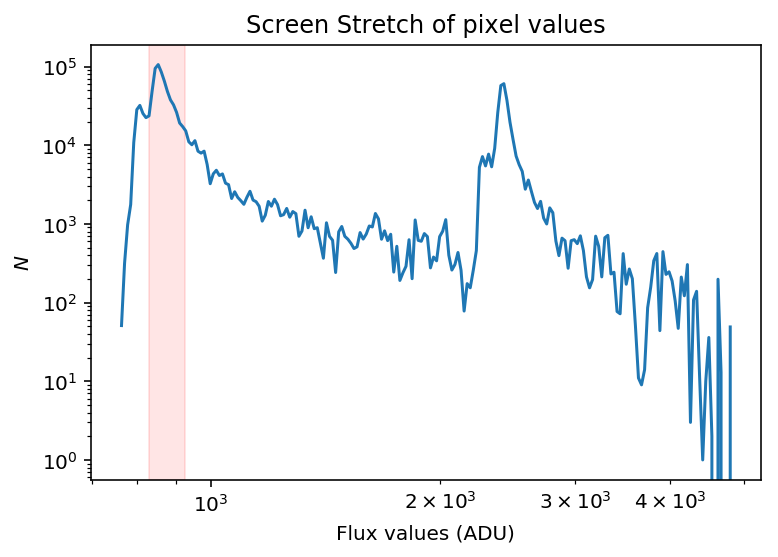

In [33]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

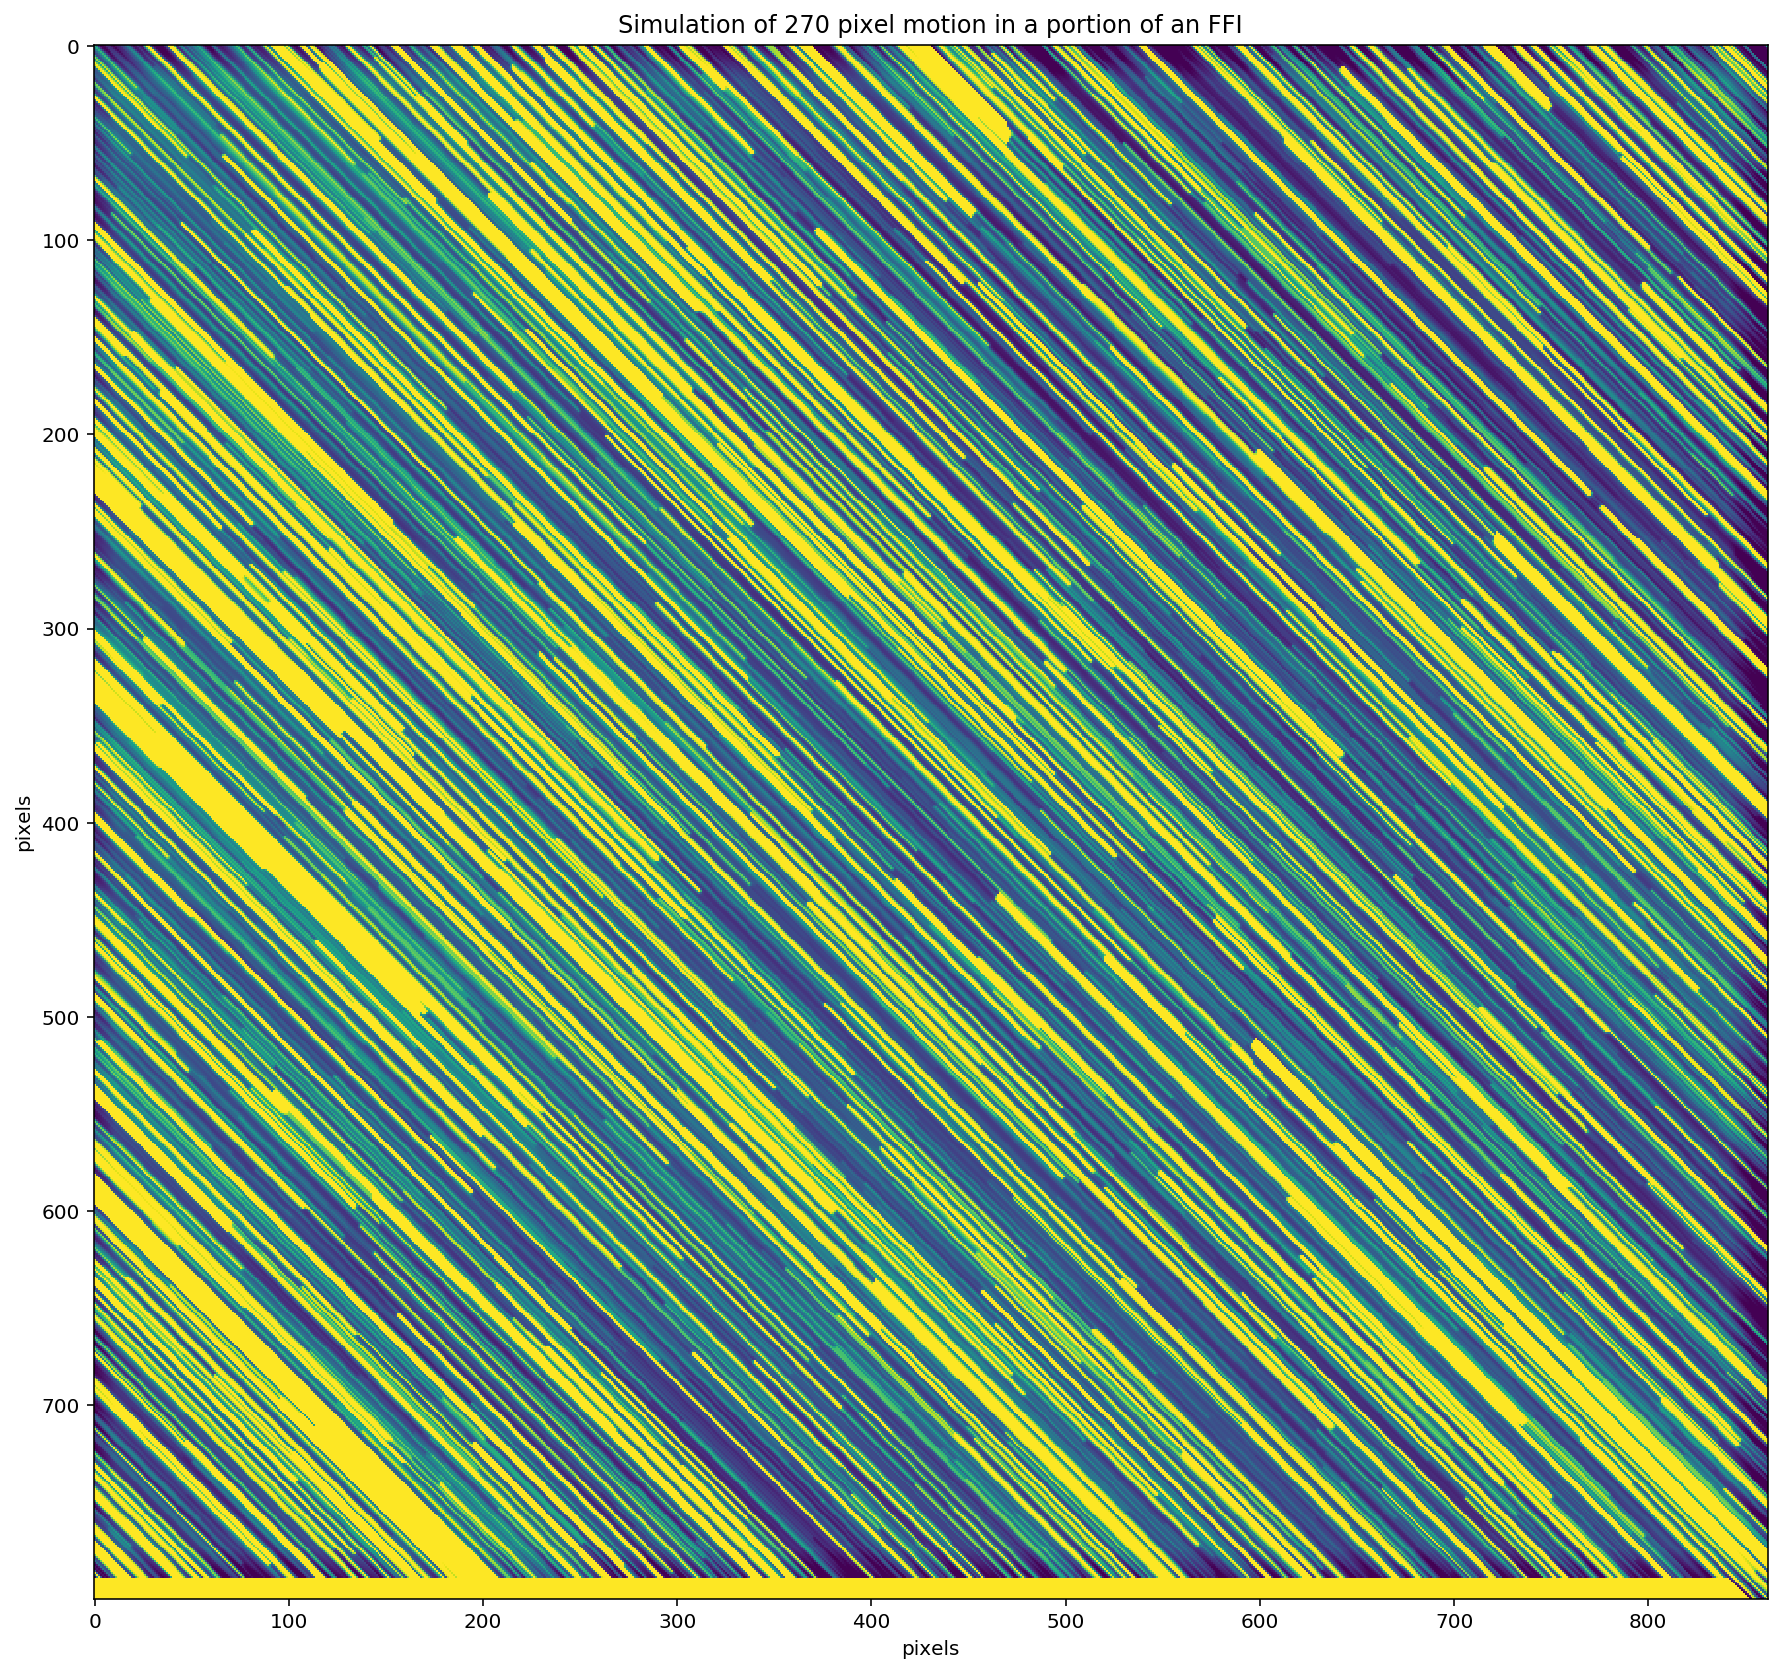

In [34]:
plt.figure(figsize=(15,15))
plt.imshow(rolled[270:, 270:], norm=norm)
plt.title('Simulation of 270 pixel motion in a portion of an FFI')
plt.xlabel('pixels')
plt.ylabel('pixels')
plt.savefig('./TWSDDL_motion_270pix_FFI_mod13p2.png', dpi=300,bbox_inches='tight');

Lots of motion, but that can be helpful from a flat-fielding perspective.